# Statistical Approach to Spam Identification
Getting up and running with R and the spamassassin email corpus downloaded from http://spamassassin.apache.org/old/publiccorpus/. Classifying using Naive Bayes and Recursive Partitioning and Classification Trees. Code is from chapter 3 of Deborah Nolan and Duncan Temple Lang's book "Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving".

#### Getting the data into R

In [1]:
# spamPath = system.file(package = "RSpamData")
spamPath = "./data"

In [2]:
list.dirs(spamPath, full.names = FALSE)

[1] ""                    "messages"            "messages/easy_ham"  
[4] "messages/easy_ham_2" "messages/hard_ham"   "messages/spam"      
[7] "messages/spam_2"

In [3]:
head(list.files(path = paste(spamPath, "messages", "spam_2", sep = .Platform$file.sep)))

[1] "00001.317e78fa8ee2f54cd4890fdc09ba8176"
[2] "00002.9438920e9a55591b18e60d1ed37d992b"
[3] "00003.590eff932f8704d8b0fcbe69d023b54d"
[4] "00004.bdcc075fa4beb5157b5dd6cd41d8887b"
[5] "00005.ed0aba4d386c5e62bc737cf3f0ed9589"
[6] "00006.3ca1f399ccda5d897fecb8c57669a283"

In [4]:
dirNames = list.files(path = paste(spamPath, "messages",
                      sep = .Platform$file.sep))
length(list.files(paste(spamPath, "messages", dirNames,
                        sep = .Platform$file.sep)))

[1] 9353

In [5]:
sapply(paste(spamPath, "messages", dirNames, 
             sep = .Platform$file.sep), 
       function(dir) length(list.files(dir)) )

./data/messages/easy_ham ./data/messages/easy_ham_2 
                      5052                       1401 
  ./data/messages/hard_ham       ./data/messages/spam 
                       501                       1001 
    ./data/messages/spam_2 
                      1398

In [6]:
fullDirNames = paste(spamPath, "messages", dirNames, 
                     sep = .Platform$file.sep)

fileNames = list.files(fullDirNames[1], full.names = TRUE)
fileNames[1]

[1] "./data/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c"

In [7]:
msg = readLines(fileNames[1])
print(head(msg))

[1] "From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002"     
[2] "Return-Path: <exmh-workers-admin@spamassassin.taint.org>"         
[3] "Delivered-To: zzzz@localhost.netnoteinc.com"                      
[4] "Received: from localhost (localhost [127.0.0.1])"                 
[5] "\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36"
[6] "\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)"     


In [8]:
#getting a subset of emails to aid in the development of email handling procedures
indx = c(1:5, 15, 27, 68, 69, 329, 404, 427, 516, 852, 971)
fn = list.files(fullDirNames[1], full.names = TRUE)[indx]
sampleEmail = sapply(fn, readLines)

#### Text Mining and Naive Bayes Classification
We'll follow the bag of words method to allow us to compute log-likelihood estimates using the naive Bayes' approach.

#### Implementing Bag of Words in R on our corpus

In [9]:
msg = sampleEmail[[1]]
which(msg == "")[1]

[1] 63

In [10]:
match("", msg)

[1] 63

In [11]:
splitPoint = match("", msg)

print(msg[ (splitPoint - 2):(splitPoint + 6) ])

[1] "List-Archive: <https://listman.spamassassin.taint.org/mailman/private/exmh-workers/>"
[2] "Date: Thu, 22 Aug 2002 18:26:25 +0700"                                               
[3] ""                                                                                    
[4] "    Date:        Wed, 21 Aug 2002 10:54:46 -0500"                                    
[5] "    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>"         
[6] "    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>"                         
[7] ""                                                                                    
[8] ""                                                                                    
[9] "  | I can't reproduce this error."                                                   


In [12]:
header = msg[1:(splitPoint-1)]
body = msg[ -(1:splitPoint) ]

In [13]:
splitMessage = function(msg) {
  splitPoint = match("", msg)
  header = msg[1:(splitPoint-1)]
  body = msg[ -(1:splitPoint) ]
  return(list(header = header, body = body))
}

In [14]:
sampleSplit = lapply(sampleEmail, splitMessage)

In [15]:
header = sampleSplit[[1]]$header
grep("Content-Type", header)

[1] 46

In [16]:
#checking for attachments. i.e. if content type is "multipart"
print(grep("multi", tolower(header[46])))

integer(0)


In [17]:
header[46]

[1] "Content-Type: text/plain; charset=us-ascii"

In [18]:
headerList = lapply(sampleSplit, function(msg) msg$header)
CTloc = sapply(headerList, grep, pattern = "Content-Type")
print(CTloc[c(1,6,7)])

$`./data/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c`
[1] 46

$`./data/messages/easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57`
[1] 54

$`./data/messages/easy_ham/00025.d685245bdc4444f44fa091e6620b20b3`
integer(0)



In [19]:
#item 7 didn't have the Content-Type key so it returned nothing!
print(sapply(headerList, function(header) {
                       CTloc = grep("Content-Type", header)
                       if (length(CTloc) == 0) return(NA)
                       CTloc
                   }))

./data/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c 
                                                             46 
./data/messages/easy_ham/00002.9c4069e25e1ef370c078db7ee85ff9ac 
                                                             45 
./data/messages/easy_ham/00003.860e3c3cee1b42ead714c5c874fe25f7 
                                                             42 
./data/messages/easy_ham/00004.864220c5b6930b209cc287c361c99af1 
                                                             30 
./data/messages/easy_ham/00005.bf27cdeaf0b8c4647ecd61b1d09da613 
                                                             44 
./data/messages/easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57 
                                                             54 
./data/messages/easy_ham/00025.d685245bdc4444f44fa091e6620b20b3 
                                                             NA 
./data/messages/easy_ham/00062.009f5a1a8fa88f0b38299ad01562bb37 
                         

In [20]:
hasAttach = sapply(headerList, function(header) {
  CTloc = grep("Content-Type", header)
  if (length(CTloc) == 0) return(FALSE)
  grepl("multi", tolower(header[CTloc])) 
})

print(hasAttach)

./data/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c 
                                                          FALSE 
./data/messages/easy_ham/00002.9c4069e25e1ef370c078db7ee85ff9ac 
                                                          FALSE 
./data/messages/easy_ham/00003.860e3c3cee1b42ead714c5c874fe25f7 
                                                          FALSE 
./data/messages/easy_ham/00004.864220c5b6930b209cc287c361c99af1 
                                                          FALSE 
./data/messages/easy_ham/00005.bf27cdeaf0b8c4647ecd61b1d09da613 
                                                          FALSE 
./data/messages/easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57 
                                                           TRUE 
./data/messages/easy_ham/00025.d685245bdc4444f44fa091e6620b20b3 
                                                          FALSE 
./data/messages/easy_ham/00062.009f5a1a8fa88f0b38299ad01562bb37 
                         

In [21]:
header = sampleSplit[[6]]$header
boundaryIdx = grep("boundary=", header)
print(header[boundaryIdx])

[1] "    boundary=\"==_Exmh_-1317289252P\";"


In [22]:
print(sub(".*boundary=\"(.*)\";.*", "\\1", header[boundaryIdx]))

[1] "==_Exmh_-1317289252P"


In [23]:
header2 = headerList[[9]]
boundaryIdx2 = grep("boundary=", header2)
print(header2[boundaryIdx2])

[1] "Content-Type: multipart/alternative; boundary=Apple-Mail-2-874629474"


In [24]:
# a bunch of testing out the functionality, skipping it
# sub('.*boundary="(.*)";.*', "\\1", header2[boundaryIdx2])

# boundary2 = gsub('"', "", header2[boundaryIdx2])

# sub(".*boundary= *(.*);?.*", "\\1", boundary2)

# boundary = gsub('"', "", header[boundaryIdx])
# sub(".*boundary= *(.*);?.*", "\\1", boundary)

# sub(".*boundary= *([^;]*);?.*", "\\1", boundary)

getBoundary = function(header) {
  boundaryIdx = grep("boundary=", header)
  boundary = gsub('"', "", header[boundaryIdx])
  gsub(".*boundary= *([^;]*);?.*", "\\1", boundary)
}

In [25]:
#print out the body of a sample message
print(sampleSplit[[6]]$body)

 [1] "--==_Exmh_-1317289252P"                                                           
 [2] "Content-Type: text/plain; charset=us-ascii"                                       
 [3] ""                                                                                 
 [4] "> From:  Chris Garrigues <cwg-exmh@DeepEddy.Com>"                                 
 [5] "> Date:  Wed, 21 Aug 2002 10:40:39 -0500"                                         
 [6] ">"                                                                                
 [7] "> > From:  Chris Garrigues <cwg-exmh@DeepEddy.Com>"                               
 [8] "> > Date:  Wed, 21 Aug 2002 10:17:45 -0500"                                       
 [9] "> >"                                                                              
[10] "> > Ouch...I'll get right on it."                                                 
[11] "> > "                                                                             
[12] "> > > From:  Ro

In [26]:
boundary = getBoundary(headerList[[15]]) 
body = sampleSplit[[15]]$body
bString = paste("--", boundary, sep = "")
bStringLocs = which(bString == body)
print(bStringLocs)

[1]  2 35


In [27]:
eString = paste("--", boundary, "--", sep = "")
eStringLoc = which(eString == body)
print(eStringLoc)

[1] 77


In [28]:
msg = body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)]
print(tail(msg))

[1] ">"     ">Yuck" ">  "   ">"     ""      ""     


In [29]:
msg = c(msg, body[ (eStringLoc + 1) : length(body) ])
print(tail(msg))

[1] ">  " ">"   ""    ""    ""    ""   


In [30]:
dropAttach = function(body, boundary){
  
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  
  if (length(bStringLocs) <= 1) return(body)
  
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  if (length(eStringLoc) == 0) 
    return(body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)])
  
  n = length(body)
  if (eStringLoc < n) 
     return( body[ c( (bStringLocs[1] + 1) : (bStringLocs[2] - 1), 
                    ( (eStringLoc + 1) : n )) ] )
  
  return( body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1) ])
}

In [31]:
print(head(sampleSplit[[1]]$body))

[1] "    Date:        Wed, 21 Aug 2002 10:54:46 -0500"                           
[2] "    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>"
[3] "    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>"                
[4] ""                                                                           
[5] ""                                                                           
[6] "  | I can't reproduce this error."                                          


In [32]:
msg = sampleSplit[[3]]$body
print(head(msg))

[1] "Man Threatens Explosion In Moscow "                                        
[2] ""                                                                          
[3] "Thursday August 22, 2002 1:40 PM"                                          
[4] "MOSCOW (AP) - Security officers on Thursday seized an unidentified man who"
[5] "said he was armed with explosives and threatened to blow up his truck in"  
[6] "front of Russia's Federal Security Services headquarters in Moscow, NTV"   


In [33]:
print(msg[ c(1, 3, 26, 27) ])

[1] "Man Threatens Explosion In Moscow "                      
[2] "Thursday August 22, 2002 1:40 PM"                        
[3] "4 DVDs Free +s&p Join Now"                               
[4] "http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM"


In [34]:
cleanMsg = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", msg))
print(cleanMsg[ c(1, 3, 26, 27) ])

[1] "man threatens explosion in moscow "                   
[2] "thursday august pm"                                   
[3] " dvds free s p join now"                              
[4] "http us click yahoo com pt ybb nxieaa mg haa gsolb tm"


In [35]:
library(tm)
stopWords = stopwords()
cleanSW = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", stopWords))
SWords = unlist(strsplit(cleanSW, "[[:blank:]]+"))
SWords = SWords[ nchar(SWords) > 1 ]
stopWords = unique(SWords)

Loading required package: NLP


In [36]:
words = unlist(strsplit(cleanMsg, "[[:blank:]]+"))

words = words[ nchar(words) > 1 ]

words = words[ !( words %in% stopWords) ]
print(head(words))

[1] "man"       "threatens" "explosion" "moscow"    "thursday"  "august"   


In [37]:
cleanText =
function(msg)   {
  tolower(gsub("[[:punct:]0-9[:space:][:blank:]]+", " ", msg))
}

findMsgWords = 
function(msg, stopWords) {
 if(is.null(msg))
  return(character())

 words = unique(unlist(strsplit(cleanText(msg), "[[:blank:]\t]+")))
 
 # drop empty and 1 letter words
 words = words[ nchar(words) > 1]
 words = words[ !( words %in% stopWords) ]
 invisible(words)
}

processAllWords = function(dirName, stopWords)
{
       # read all files in the directory
  fileNames = list.files(dirName, full.names = TRUE)
       # drop files that are not email, i.e., cmds
  notEmail = grep("cmds$", fileNames)
  if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]

  messages = lapply(fileNames, readLines, encoding = "latin1")
  
       # split header and body
  emailSplit = lapply(messages, splitMessage)
       # put body and header in own lists
  bodyList = lapply(emailSplit, function(msg) msg$body)
  headerList = lapply(emailSplit, function(msg) msg$header)
  rm(emailSplit)
  
       # determine which messages have attachments
  hasAttach = sapply(headerList, function(header) {
    CTloc = grep("Content-Type", header)
    if (length(CTloc) == 0) return(0)
    multi = grep("multi", tolower(header[CTloc])) 
    if (length(multi) == 0) return(0)
    multi
  })
  
  hasAttach = which(hasAttach > 0)
  
       # find boundary strings for messages with attachments
  boundaries = sapply(headerList[hasAttach], getBoundary)
  
       # drop attachments from message body
  bodyList[hasAttach] = mapply(dropAttach, bodyList[hasAttach], 
                               boundaries, SIMPLIFY = FALSE)
  
       # extract words from body
  msgWordsList = lapply(bodyList, findMsgWords, stopWords)
  
  invisible(msgWordsList)
}

In [38]:
msgWordsList = lapply(fullDirNames, processAllWords, 
                      stopWords = stopWords) 

#get number of messages in each directory
numMsgs = sapply(msgWordsList, length)
print(numMsgs)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"

[1] 5051 1400  500 1000 1397


In [39]:
#create logical labels for each message based on which folder they are in:
#the first 3 are ham the last 2 are spam
isSpam = rep(c(FALSE, FALSE, FALSE, TRUE, TRUE), numMsgs)

In [40]:
#flatten into a single list of msgs
msgWordsList = unlist(msgWordsList, recursive = FALSE)

#### Implementing Naive Bayes
As explained in the text we are approximating the conditional probability below as follows:

<center>$\mathbb{P}\big(\text{a word is present }\big\vert\text{ spam}\big) \approx \dfrac{\text{# of spam messages with this word }+1/2}{\text{# of spam messages} + 1/2}$</center>

and

<center>$\mathbb{P}\big(\text{a word is absent }\big\vert\text{ spam}\big) \approx \dfrac{\text{# of spam messages without this word }+1/2}{\text{# of spam messages} + 1/2}$</center>

We end up taking the log of the ratio of these probabilities to simplify computation (products become sums) and also for some better statistical properties. The log likelihood ratio is computed as:

<center>$\sum\limits_{\text{words in a message}}\text{log}\mathbb{P}\big(\text{word present }\big\vert\text{ spam}\big) - \text{log}\mathbb{P}\big(\text{word present }\big\vert\text{ ham}\big)$</center>
<center>$ + \sum\limits_{\text{words not in a message}}\text{log}\mathbb{P}\big(\text{word absent }\big\vert\text{ spam}\big) - \text{log}\mathbb{P}\big(\text{word absent }\big\vert\text{ ham}\big)$</center>
<center>$ + \text{log}\mathbb{P}\big(\text{spam}\big) - \text{log}\mathbb{P}\big(\text{ham}\big)$</center>

Again, we recognize the naivety in that the occurrence of these words in fact is not independent of one another but it has been shown that this simplification still produces decent results.

In [41]:
#tally up number of span and ham to help us know how much to sample from each category
numEmail = length(isSpam)
numSpam = sum(isSpam)
numHam = numEmail - numSpam

In [42]:
#a typical unbalanced problem, may want to maintain relative proportions when sampling
numHam/numEmail
numSpam/numEmail

[1] 0.7435815

[1] 0.2564185

In [43]:
#set seed for reproducibility
set.seed(418910)

#get indices for spam and ham messages to aid in proportional sampling
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

#select based on those test indices
testMsgWords = c((msgWordsList[isSpam])[testSpamIdx],
                 (msgWordsList[!isSpam])[testHamIdx] )
trainMsgWords = c((msgWordsList[isSpam])[ - testSpamIdx], 
                  (msgWordsList[!isSpam])[ - testHamIdx])

testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(testSpamIdx), length(testHamIdx)))
trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(testSpamIdx), 
                   numHam - length(testHamIdx)))

In [44]:
#get our bag of words
#keep in mind there are a lot of gibberish words from un-parsed URLs and also
#a bunch of repeats that should be stemmed before getting the unique vector
#apparently we'll find later that without this cleaning the classifier still
#performs well!
bow = unique(unlist(trainMsgWords))

length(bow)

[1] 80059

In [45]:
#make a vector to hold counts of all words from BOW
spamWordCounts = rep(0, length(bow))
#name each element for the word it represents in BOW
names(spamWordCounts) = bow

In [46]:
#example, what does this do?
tmp = lapply(trainMsgWords[trainIsSpam], unique) #get unique words for each message returned in a list of vectors
tt = table( unlist(tmp) ) #make table from unlisted tmp
spamWordCounts[ names(tt) ] = tt #add those counts to spamWordCounts in the appropriate rownames

In [47]:
computeFreqs =
function(wordsList, spam, bow = unique(unlist(wordsList)))
{
   # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow), 
                     dimnames = list(c("spam", "ham", 
                                        "presentLogOdds", 
                                        "absentLogOdds"),  bow))

   # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5

   # Similarly for ham messages
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  


   # Find the total number of spam and ham
  numSpam = sum(spam)
  numHam = length(spam) - numSpam

   # Prob(word|spam) and Prob(word | ham)
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
   # log odds
  wordTable["presentLogOdds", ] = 
     log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = 
     log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))

  invisible(wordTable)
}

In [48]:
trainTable = computeFreqs(trainMsgWords, trainIsSpam)

In [49]:
newMsg = testMsgWords[[1]] #first one is spam

#drop words that didn't show up in the BOW
newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]

#find the words that were in BOW
present = colnames(trainTable) %in% newMsg

#compute the log of the ratio of the probability a message is spam versus ham
#large positive indicates it is spam
sum(trainTable["presentLogOdds", present]) + 
  sum(trainTable["absentLogOdds", !present])

[1] 255.0476

In [50]:
#get the first ham by taking the first index of non-spams
newMsg = testMsgWords[[ which(!testIsSpam)[1] ]]
newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]
present = (colnames(trainTable) %in% newMsg)
#large negative indicates ham
sum(trainTable["presentLogOdds", present]) + 
     sum(trainTable["absentLogOdds", !present])

[1] -124.3275

In [51]:
# put the above steps in a function
computeMsgLLR = function(words, freqTable) 
{
       # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]

       # Find which words are present
  present = colnames(freqTable) %in% words

  sum(freqTable["presentLogOdds", present]) +
    sum(freqTable["absentLogOdds", !present])
}

In [52]:
testLLR = sapply(testMsgWords, computeMsgLLR, trainTable)

In [53]:
#recall that testIsSpam is a vector of messages with label of TRUE or FALSE
#where TRUE indicates spam
tapply(testLLR, testIsSpam, summary)

$`FALSE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1361.89  -127.06  -101.18  -116.25   -81.26   700.23 

$`TRUE`
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  -60.574     6.369    49.837   137.546   131.719 23518.028 


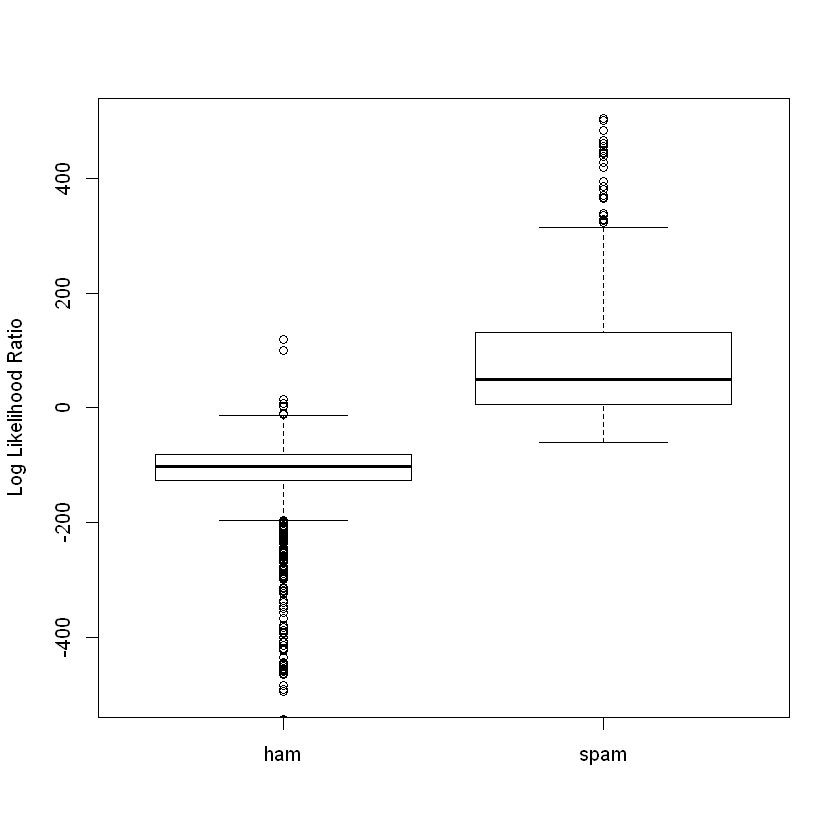

In [54]:
# pdf("SP_Boxplot.pdf", width = 6, height = 6)
spamLab = c("ham", "spam")[1 + testIsSpam]
boxplot(testLLR ~ spamLab, ylab = "Log Likelihood Ratio",
      #  main = "Log Likelihood Ratio for Randomly Chosen Test Messages",
        ylim=c(-500, 500))
# dev.off()

In [55]:
#function to calculate type 1 error rate so we can test out some threshold values
typeIErrorRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau #returns indices for positives (greater than tau means spam)
  sum(classify & !spam)/sum(!spam) #sum all false positives divide by sum of all actual positives
}

In [56]:
typeIErrorRate(0, testLLR,testIsSpam)

[1] 0.003452741

In [57]:
typeIErrorRate(-20, testLLR,testIsSpam)

[1] 0.005610703

In [58]:
#lets create two vectorized functions for computing type 1 and type 2 error rates
#we don't need to pass in a vector of thresholds though, instead this function
#looks at the ham messages and we recognize that the number of type 1 errors decreases
#by 1 at each of these values and so is i/(# of ham messages). i.e. we'll test for 
#thresholds from (N:1)/N
typeIErrorRates = 
function(llrVals, isSpam) 
{
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]

  idx = which(!isSpam)
  N = length(idx)
  list(error = (N:1)/N, values = llrVals[idx])
}

#similarly for type 2 error except we go from 1:N
typeIIErrorRates = function(llrVals, isSpam) {
    
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]
    
    
  idx = which(isSpam)
  N = length(idx)
  list(error = (1:(N))/N, values = llrVals[idx])
  }  

In [59]:
xI = typeIErrorRates(testLLR, testIsSpam)
xII = typeIIErrorRates(testLLR, testIsSpam)
tau01 = round(min(xI$values[xI$error <= 0.01]))
t2 = max(xII$error[ xII$values < tau01 ])

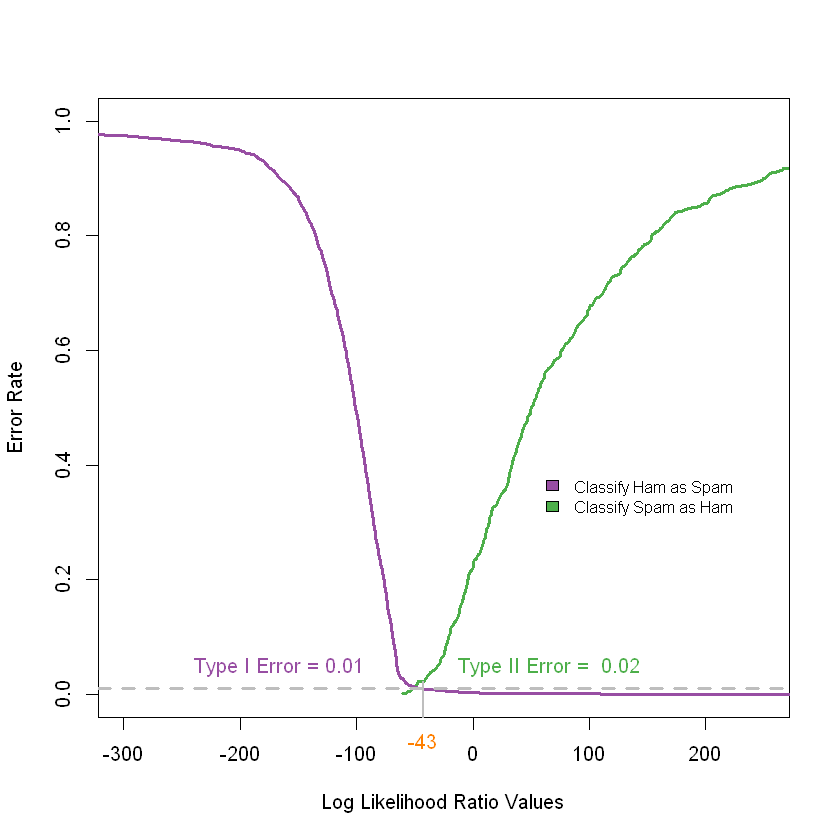

In [60]:
# pdf("LinePlotTypeI+IIErrors.pdf", width = 8, height = 6)

library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, 
         lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(t2, digits = 2)), 
     col = cols[1])

# dev.off()

In [61]:
#perform 5-fold cross validation to better select a threshold
k = 5 #set k
numTrain = length(trainMsgWords) #get number of training observations
partK = sample(numTrain) #randomly sample digits between 1 and numTrain
tot = k * floor(numTrain/k) #set the total number of observations we'll use in all k folds, ensures even amounts
partK = matrix(partK[1:tot], ncol = k) #matrix using the the first tot items in the vector version of partK

testFoldOdds = NULL #a blank vector: we'll append the Odds vectors produced for each test fold
for (i in 1:k) {
  foldIdx = partK[ , i] #use column i in partK to test, use the rest for training
  trainTabFold = computeFreqs(trainMsgWords[-foldIdx], trainIsSpam[-foldIdx])
  testFoldOdds = c(testFoldOdds, 
               sapply(trainMsgWords[ foldIdx ], computeMsgLLR, trainTabFold))
}

testFoldSpam = NULL #blank vector that gets the labels for spam or not spam of each test fold
for (i in 1:k) {
  foldIdx = partK[ , i]
  testFoldSpam = c(testFoldSpam, trainIsSpam[foldIdx])
}

#now we have two vectors that contain the odds and their actual labels produced during
#k-fold cross validation, now we just compute the error rates and then find the 
#best tau for a type 1 error rate less than or equal to 1%
xFoldI = typeIErrorRates(testFoldOdds, testFoldSpam)
xFoldII = typeIIErrorRates(testFoldOdds, testFoldSpam)
tauFoldI = round(min(xFoldI$values[xFoldI$error <= 0.01]))
tFold2 = max(xFoldII$error[ xFoldII$values < tauFoldI ])

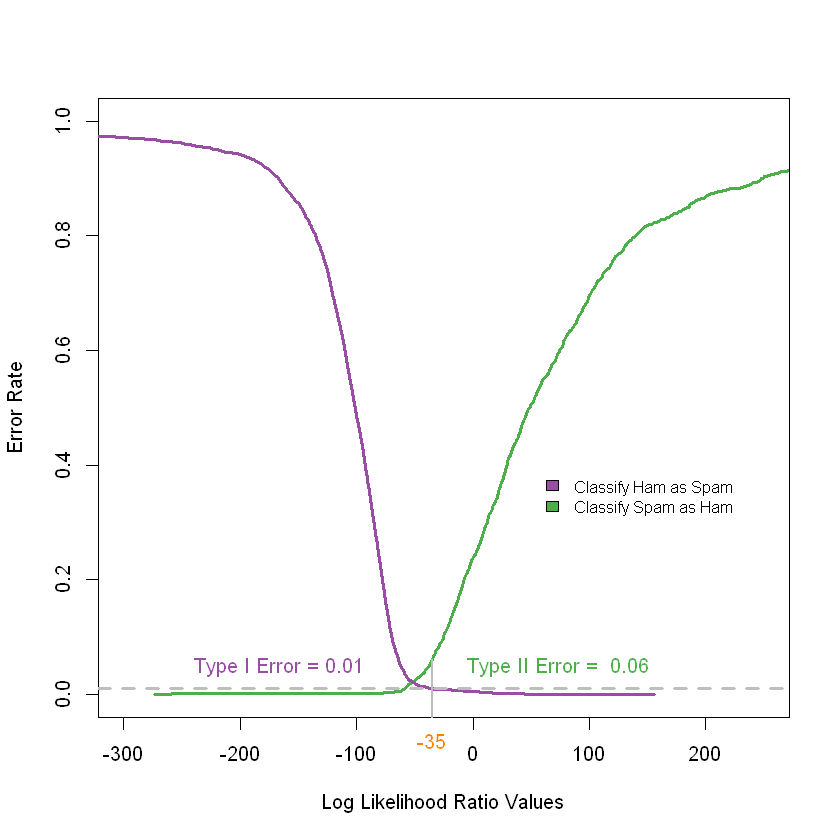

In [62]:
plot(xFoldII$error ~ xFoldII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate")
points(xFoldI$error ~ xFoldI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tauFoldI, side = 1, line = 0.5, at = tauFoldI, col = cols[3])
segments(x0 = tauFoldI, y0 = -.50, x1 = tauFoldI, y1 = tFold2, 
         lwd = 2, col = "grey")
text(tauFoldI + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(tFold2, digits = 2)), 
     col = cols[1])

In [80]:
#some of this code is my own, I copied some of the authors' code and modified it to produce 
#the ROC plot that follows
#need true and false positive rates
truePosRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau
  sum(classify & spam)/sum(spam)
}
falsePosRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau #get all positives
  sum(classify & !spam)/sum(!spam) #sum all positives that were actually negative, divide by all negatives
}

In [98]:
#now collect FPR and TPR for each fold using the suggested threshold from the previous analysis
k = 10 #set k
numTrain = length(trainMsgWords) #get number of training observations
partK = sample(numTrain) #randomly sample digits between 1 and numTrain
tot = k * floor(numTrain/k) #set the total number of observations we'll use in all k folds, ensures even amounts
partK = matrix(partK[1:tot], ncol = k) #matrix using the the first tot items in the vector version of partK

testFoldOdds = NULL #a blank vector: we'll append the Odds vectors produced for each test fold
for (i in 1:k) {
  foldIdx = partK[ , i] #use column i in partK to test, use the rest for training
  trainTabFold = computeFreqs(trainMsgWords[-foldIdx], trainIsSpam[-foldIdx])
  testFoldOdds = c(testFoldOdds, 
               sapply(trainMsgWords[ foldIdx ], computeMsgLLR, trainTabFold))
}

testFoldSpam = NULL #blank vector that gets the labels for spam or not spam of each test fold
for (i in 1:k) {
  foldIdx = partK[ , i]
  testFoldSpam = c(testFoldSpam, trainIsSpam[foldIdx])
}
testFoldOdds = matrix(testFoldOdds, ncol=k)
testFoldSpam = matrix(testFoldSpam, ncol=k)

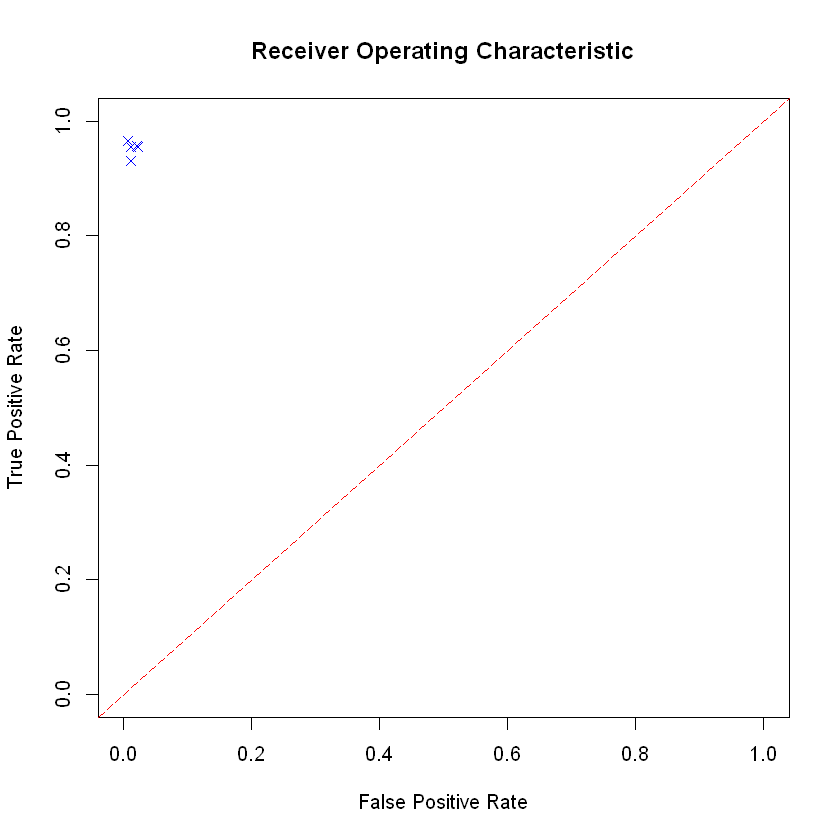

In [106]:
#sort of anticlimactic but shows results right where we want to be
cvrates = cbind("fold" = 1:k,
              "tpr" = unlist(lapply(1:5, function(i) truePosRate(-35, testFoldOdds[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:5, function(i) falsePosRate(-35, testFoldOdds[,i], testFoldSpam[,i]))))
cvrates = cvrates[order(cvrates[,3]),] #sort in order of increasing fpr
plot(cvrates[,3], cvrates[,2], ylim=c(0,1), xlim=c(0,1), pch=4, col="blue",
     xlab="False Positive Rate", ylab="True Positive Rate", main="Receiver Operating Characteristic")
abline(0, 1, lty=5, col="red")

In [107]:
#an exercise of the author showing how we may like to improve the accuracy of our computations
smallNums = rep((1/2)^40, 2000000)
largeNum = 10000

print(sum(smallNums), digits = 20)

print(largeNum + sum(smallNums), digits = 20)

for (i in 1:length(smallNums)) {
  largeNum = largeNum + smallNums[i]
}
print(largeNum, digits = 20)

[1] 1.8189894035458565e-06
[1] 10000.000001818989
[1] 10000


In [ ]:
sampleSplit = lapply(sampleEmail, splitMessage)

header = sampleSplit[[1]]$header
header[1:12]

header[1] = sub("^From", "Top-From:", header[1])
header[1]

headerPieces = read.dcf(textConnection(header), all = TRUE)

headerPieces[, "Delivered-To"]


headerVec = unlist(headerPieces)
dupKeys = sapply(headerPieces, function(x) length(unlist(x)))
names(headerVec) = rep(colnames(headerPieces), dupKeys)

headerVec[ which(names(headerVec) == "Delivered-To") ]

length(headerVec)

length(unique(names(headerVec)))

processHeader = function(header)
{
       # modify the first line to create a key:value pair
  header[1] = sub("^From", "Top-From:", header[1])
  
  headerMat = read.dcf(textConnection(header), all = TRUE)
  headerVec = unlist(headerMat)
  
  dupKeys = sapply(headerMat, function(x) length(unlist(x)))
  names(headerVec) = rep(colnames(headerMat), dupKeys)
  
  return(headerVec)
}

headerList = lapply(sampleSplit, 
                    function(msg) {
                      processHeader(msg$header)} )

contentTypes = sapply(headerList, function(header) 
                                        header["Content-Type"])
names(contentTypes) = NULL
contentTypes

hasAttach = grep("^ *multi", tolower(contentTypes))
hasAttach

boundaries = getBoundary(contentTypes[ hasAttach ])
boundaries

boundary = boundaries[9]
body = sampleSplit[[15]]$body

bString = paste("--", boundary, sep = "")
bStringLocs = which(bString == body)
bStringLocs

eString = paste("--", boundary, "--", sep = "")
eStringLoc = which(eString == body)
eStringLoc

diff(c(bStringLocs[-1], eStringLoc))

### This code has mistakes in it - and we fix them later!
processAttach = function(body, contentType){
  
  boundary = getBoundary(contentType)
  
  bString = paste("--", boundary, "$", sep = "")
  bStringLocs = grep(bString, body)
  
  eString = paste("--", boundary, "--$", sep = "")
  eStringLoc = grep(eString, body)
  
  n = length(body)
  
  if (length(eStringLoc) == 0) eStringLoc = n + 1
  if (length(bStringLocs) == 1) attachLocs = NULL
  else attachLocs = c(bStringLocs[-1],  eStringLoc)
  
  msg = body[ (bStringLocs[1] + 1) : min(n, (bStringLocs[2] - 1), 
                                         na.rm = TRUE)]
  
  if ( eStringLoc < n )
    msg = c(msg, body[ (eStringLoc + 1) : n ])
  
  if ( !is.null(attachLocs) ) {
    attachLens = diff(attachLocs, lag = 1) 
    attachTypes = mapply(function(begL, endL) {
      contentTypeLoc = grep("[Cc]ontent-[Tt]ype", body[ (begL + 1) : (endL - 1)])
      contentType = body[ begL + contentTypeLoc]
      contentType = gsub('"', "", contentType )
      MIMEType = sub(" *Content-Type: *([^;]*);?.*", "\\1", contentType)
      return(MIMEType)
    }, attachLocs[-length(attachLocs)], attachLocs[-1])
  }
  
  if (is.null(attachLocs)) return(list(body = msg, attachInfo = NULL) )
  else return(list(body = msg, 
                   attachDF = data.frame(aLen = attachLens, 
                                         aType = attachTypes,
                                         stringsAsFactors = FALSE)))                                
}

bodyList = lapply(sampleSplit, function(msg) msg$body)
attList = mapply(processAttach, bodyList[hasAttach], 
                 contentTypes[hasAttach], 
                 SIMPLIFY = FALSE)

lens = sapply(attList, function(processedA) 
                           processedA$attachDF$aLen)
head(lens)

attList[[2]]$attachDF

body = bodyList[hasAttach][[2]]
length(body)

body[35:45]

processAttach = function(body, contentType){

  n = length(body)
  boundary = getBoundary(contentType)
 
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  
  if (length(eStringLoc) == 0) eStringLoc = n
  if (length(bStringLocs) <= 1) {
    attachLocs = NULL
    msgLastLine = n
    if (length(bStringLocs) == 0) bStringLocs = 0
  } else {
    attachLocs = c(bStringLocs[ -1 ],  eStringLoc)
    msgLastLine = bStringLocs[2] - 1
  }
  
  msg = body[ (bStringLocs[1] + 1) : msgLastLine] 
  if ( eStringLoc < n )
    msg = c(msg, body[ (eStringLoc + 1) : n ])
  
  if ( !is.null(attachLocs) ) {
    attachLens = diff(attachLocs, lag = 1) 
    attachTypes = mapply(function(begL, endL) {
      CTloc = grep("^[Cc]ontent-[Tt]ype", body[ (begL + 1) : (endL - 1)])
      if ( length(CTloc) == 0 ) {
        MIMEType = NA
      } else {
        CTval = body[ begL + CTloc[1] ]
        CTval = gsub('"', "", CTval )
        MIMEType = sub(" *[Cc]ontent-[Tt]ype: *([^;]*);?.*", "\\1", CTval)   
      }
      return(MIMEType)
    }, attachLocs[-length(attachLocs)], attachLocs[-1])
  }
  
  if (is.null(attachLocs)) return(list(body = msg, attachDF = NULL) )
  return(list(body = msg, 
             attachDF = data.frame(aLen = attachLens, 
                                     aType = unlist(attachTypes),
                                     stringsAsFactors = FALSE)))                                
}                       

readEmail = function(dirName) {
       # retrieve the names of files in directory
  fileNames = list.files(dirName, full.names = TRUE)
       # drop files that are not email
  notEmail = grep("cmds$", fileNames)
  if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]

       # read all files in the directory
  lapply(fileNames, readLines, encoding = "latin1")
}

processAllEmail = function(dirName, isSpam = FALSE)
{
       # read all files in the directory
  messages = readEmail(dirName)
  fileNames = names(messages)
  n = length(messages)
  
       # split header from body
  eSplit = lapply(messages, splitMessage)
  rm(messages)

       # process header as named character vector
  headerList = lapply(eSplit, function(msg) 
                                 processHeader(msg$header))
  
       # extract content-type key
  contentTypes = sapply(headerList, function(header) 
                                       header["Content-Type"])
  
       # extract the body
  bodyList = lapply(eSplit, function(msg) msg$body)
  rm(eSplit)

       # which email have attachments
  hasAttach = grep("^ *multi", tolower(contentTypes))

       # get summary stats for attachments and the shorter body
  attList = mapply(processAttach, bodyList[hasAttach], 
                   contentTypes[hasAttach], SIMPLIFY = FALSE)
  
  bodyList[hasAttach] = lapply(attList, function(attEl) 
                                           attEl$body)
 
  attachInfo = vector("list", length = n )
  attachInfo[ hasAttach ] = lapply(attList, 
                                  function(attEl) attEl$attachDF)
 
       # prepare return structure
  emailList = mapply(function(header, body, attach, isSpam) {
                       list(isSpam = isSpam, header = header, 
                            body = body, attach = attach)
                     },
                     headerList, bodyList, attachInfo, 
                     rep(isSpam, n), SIMPLIFY = FALSE )
  names(emailList) = fileNames
  
  invisible(emailList)
}

emailStruct = mapply(processAllEmail, fullDirNames,
                     isSpam = rep( c(FALSE, TRUE), 3:2))      
emailStruct = unlist(emailStruct, recursive = FALSE)

sampleStruct = emailStruct[ indx ]

save(emailStruct, file="emailXX.rda")

header = sampleStruct[[1]]$header
subject = header["Subject"]
els = strsplit(subject, "")
all(els %in% LETTERS)

testSubject = c("DEAR MADAME", "WINNER!", "")

els = strsplit(testSubject, "")
sapply(els, function(subject) all(subject %in% LETTERS))


gsub("[[:punct:] ]", "", testSubject)

gsub("[^[:alpha:]]", "", testSubject)

isYelling = function(msg) {
  if ( "Subject" %in% names(msg$header) ) {
     el = gsub("[^[:alpha:]]", "", msg$header["Subject"])
     if (nchar(el) > 0) 
        nchar(gsub("[A-Z]", "", el)) < 1
     else 
        FALSE
  } else 
    NA
}

perCaps =
function(msg)
{
  body = paste(msg$body, collapse = "")

       # Return NA if the body of the message is "empty"
  if(length(body) == 0 || nchar(body) == 0) return(NA)

       # Eliminate non-alpha characters
  body = gsub("[^[:alpha:]]", "", body)
  capText = gsub("[^A-Z]", "", body)
  100 * nchar(capText)/nchar(body)
}

sapply(sampleStruct, perCaps)

funcList = list( 
 isRe = function(msg) {
       "Subject" %in% names(msg$header) &&
         length(grep("^[ \t]*Re:", msg$header[["Subject"]])) > 0
  },
  numLines = function(msg) 
                length(msg$body),
  isYelling = function(msg) {
    if ( "Subject" %in% names(msg$header) ) {
       el = gsub("[^[:alpha:]]", "", msg$header["Subject"])
       if (nchar(el) > 0) 
         nchar(gsub("[A-Z]", "", el)) < 1
       else 
         FALSE
    }
    else NA
  },
  perCaps = function(msg) {
    body = paste(msg$body, collapse = "")

         # Return NA if the body of the message is "empty"
    if(length(body) == 0 || nchar(body) == 0) return(NA)

         # Eliminate non-alpha characters
    body = gsub("[^[:alpha:]]", "", body)
    capText = gsub("[^A-Z]", "", body)
    100 * nchar(capText)/nchar(body)
  }
)

lapply(funcList, function(func) 
                   sapply(sampleStruct, function(msg) func(msg)))

createDerivedDF =
function(email = emailStruct, operations = funcList, 
         verbose = FALSE)
{
  els = lapply(names(operations),
               function(id) {
                 if(verbose) print(id)
                 e = operations[[id]]
                 v = if(is.function(e)) 
                        sapply(email, e)
                      else 
                        sapply(email, function(msg) eval(e))
                 v
         })

   df = as.data.frame(els)
   names(df) = names(operations)
   invisible(df)
}

sampleDF = createDerivedDF(sampleStruct)
head(sampleDF)

funcList = list(
  isSpam =
    expression(msg$isSpam)
  ,
  isRe =
    function(msg) {
      # Can have a Fwd: Re:  ... but we are not looking for this here.
      # We may want to look at In-Reply-To field.
      "Subject" %in% names(msg$header) && 
        length(grep("^[ \t]*Re:", msg$header[["Subject"]])) > 0
    }
  ,
  numLines =
    function(msg) length(msg$body)
  ,
  bodyCharCt =
    function(msg)
      sum(nchar(msg$body))
  ,
  underscore =
    function(msg) {
      if(!"Reply-To" %in% names(msg$header))
        return(FALSE)
      
      txt <- msg$header[["Reply-To"]]
      length(grep("_", txt)) > 0  && 
        length(grep("[0-9A-Za-z]+", txt)) > 0
    }
  ,
  subExcCt = 
    function(msg) {
      x = msg$header["Subject"]
      if(length(x) == 0 || sum(nchar(x)) == 0 || is.na(x))
        return(NA)
      
      sum(nchar(gsub("[^!]","", x)))
    }
  ,
  subQuesCt =
    function(msg) {
      x = msg$header["Subject"]
      if(length(x) == 0 || sum(nchar(x)) == 0 || is.na(x))
        return(NA)
      
      sum(nchar(gsub("[^?]","", x)))
    }
  ,
  numAtt = 
    function(msg) {
      if (is.null(msg$attach)) return(0)
      else nrow(msg$attach)
    }
   
  ,
  priority =
    function(msg) {
      ans <- FALSE
      # Look for names X-Priority, Priority, X-Msmail-Priority
      # Look for high any where in the value
      ind = grep("priority", tolower(names(msg$header)))
      if (length(ind) > 0)  {
        ans <- length(grep("high", tolower(msg$header[ind]))) >0
      }
      ans
    }
  ,
  numRec =
    function(msg) {
      # unique or not.
      els = getMessageRecipients(msg$header)
      
      if(length(els) == 0)
        return(NA)
      
      # Split each line by ","  and in each of these elements, look for
      # the @ sign. This handles
      tmp = sapply(strsplit(els, ","), function(x) grep("@", x))
      sum(sapply(tmp, length))
    }
  ,
  perCaps =
    function(msg)
    {
      body = paste(msg$body, collapse = "")
      
      # Return NA if the body of the message is "empty"
      if(length(body) == 0 || nchar(body) == 0) return(NA)
      
      # Eliminate non-alpha characters and empty lines 
      body = gsub("[^[:alpha:]]", "", body)
      els = unlist(strsplit(body, ""))
      ctCap = sum(els %in% LETTERS)
      100 * ctCap / length(els)
    }
  ,
  isInReplyTo =
    function(msg)
    {
      "In-Reply-To" %in% names(msg$header)
    }
  ,
  sortedRec =
    function(msg)
    {
      ids = getMessageRecipients(msg$header)
      all(sort(ids) == ids)
    }
  ,
  subPunc =
    function(msg)
    {
      if("Subject" %in% names(msg$header)) {
        el = gsub("['/.:@-]", "", msg$header["Subject"])
        length(grep("[A-Za-z][[:punct:]]+[A-Za-z]", el)) > 0
      }
      else
        FALSE
    },
  hour =
    function(msg)
    {
      date = msg$header["Date"]
      if ( is.null(date) ) return(NA)
      # Need to handle that there may be only one digit in the hour
      locate = regexpr("[0-2]?[0-9]:[0-5][0-9]:[0-5][0-9]", date)
      
      if (locate < 0)
        locate = regexpr("[0-2]?[0-9]:[0-5][0-9]", date)
      if (locate < 0) return(NA)
      
      hour = substring(date, locate, locate+1)
      hour = as.numeric(gsub(":", "", hour))
      
      locate = regexpr("PM", date)
      if (locate > 0) hour = hour + 12
      
      locate = regexpr("[+-][0-2][0-9]00", date)
      if (locate < 0) offset = 0
      else offset = as.numeric(substring(date, locate, locate + 2))
      (hour - offset) %% 24
    }
  ,
  multipartText =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      numAtt = nrow(msg$attach)
      
      types = 
        length(grep("(html|plain|text)", msg$attach$aType)) > (numAtt/2)
    }
  ,
  hasImages =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      
      length(grep("^ *image", tolower(msg$attach$aType))) > 0
    }
  ,
  isPGPsigned =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      
      length(grep("pgp", tolower(msg$attach$aType))) > 0
    },
  perHTML =
    function(msg)
    {
      if(! ("Content-Type" %in% names(msg$header))) return(0)
      
      el = tolower(msg$header["Content-Type"]) 
      if (length(grep("html", el)) == 0) return(0)
      
      els = gsub("[[:space:]]", "", msg$body)
      totchar = sum(nchar(els))
      totplain = sum(nchar(gsub("<[^<]+>", "", els )))
      100 * (totchar - totplain)/totchar
    },
  subSpamWords =
    function(msg)
    {
      if("Subject" %in% names(msg$header))
        length(grep(paste(SpamCheckWords, collapse = "|"), 
                    tolower(msg$header["Subject"]))) > 0
      else
        NA
    }
  ,
  subBlanks =
    function(msg)
    {
      if("Subject" %in% names(msg$header)) {
        x = msg$header["Subject"]
        # should we count blank subject line as 0 or 1 or NA?
        if (nchar(x) == 1) return(0)
        else 100 *(1 - (nchar(gsub("[[:blank:]]", "", x))/nchar(x)))
      } else NA
    }
  ,
  noHost =
    function(msg)
    {
      # Or use partial matching.
      idx = pmatch("Message-", names(msg$header))
      
      if(is.na(idx)) return(NA)
      
      tmp = msg$header[idx]
      return(length(grep(".*@[^[:space:]]+", tmp)) ==  0)
    }
  ,
  numEnd =
    function(msg)
    {
      # If we just do a grep("[0-9]@",  )
      # we get matches on messages that have a From something like
      # " \"marty66@aol.com\" <synjan@ecis.com>"
      # and the marty66 is the "user's name" not the login
      # So we can be more precise if we want.
      x = names(msg$header)
      if ( !( "From" %in% x) ) return(NA)
      login = gsub("^.*<", "", msg$header["From"])
      if ( is.null(login) ) 
        login = gsub("^.*<", "", msg$header["X-From"])
      if ( is.null(login) ) return(NA)
      login = strsplit(login, "@")[[1]][1]
      length(grep("[0-9]+$", login)) > 0
    },
  isYelling =
    function(msg)
    {
      if ( "Subject" %in% names(msg$header) ) {
        el = gsub("[^[:alpha:]]", "", msg$header["Subject"])
        if (nchar(el) > 0) nchar(gsub("[A-Z]", "", el)) < 1
        else FALSE
      }
      else
        NA
    },
  forwards =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0 || sum(nchar(x)) == 0)
        return(NA)
      
      ans = length(grep("^[[:space:]]*>", x))
      100 * ans / length(x)
    },
  isOrigMsg =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("^[^[:alpha:]]*original[^[:alpha:]]+message[^[:alpha:]]*$", 
                  tolower(x) ) ) > 0
    },
  isDear =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("^[[:blank:]]*dear +(sir|madam)\\>", 
                  tolower(x))) > 0
    },
  isWrote =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("(wrote|schrieb|ecrit|escribe):", tolower(x) )) > 0
    },
  avgWordLen =
    function(msg)
    {
      txt = paste(msg$body, collapse = " ")
      if(length(txt) == 0 || sum(nchar(txt)) == 0) return(0)
      
      txt = gsub("[^[:alpha:]]", " ", txt)
      words = unlist(strsplit(txt, "[[:blank:]]+"))
      wordLens = nchar(words)
      mean(wordLens[ wordLens > 0 ])
    }
  ,
  numDlr =
    function(msg)
    {
      x = paste(msg$body, collapse = "")
      if(length(x) == 0 || sum(nchar(x)) == 0)
        return(NA)
      
      nchar(gsub("[^$]","", x))
    }
)


SpamCheckWords =
  c("viagra", "pounds", "free", "weight", "guarantee", "million", 
    "dollars", "credit", "risk", "prescription", "generic", "drug",
    "financial", "save", "dollar", "erotic", "million", "barrister",
    "beneficiary", "easy", 
    "money back", "money", "credit card")


getMessageRecipients =
  function(header)
  {
    c(if("To" %in% names(header))  header[["To"]] else character(0),
      if("Cc" %in% names(header))  header[["Cc"]] else character(0),
      if("Bcc" %in% names(header)) header[["Bcc"]] else character(0)
    )
  }

emailDF = createDerivedDF(emailStruct)
dim(emailDF)
#save(emailDF, file = "spamAssassinDerivedDF.rda")

load("Data/spamAssassinDerivedDF.rda")
dim(emailDF)

perCaps2 =
function(msg)
{
  body = paste(msg$body, collapse = "")

       # Return NA if the body of the message is "empty"
  if(length(body) == 0 || nchar(body) == 0) return(NA)

       # Eliminate non-alpha characters and empty lines 
  body = gsub("[^[:alpha:]]", "", body)
  els = unlist(strsplit(body, ""))
  ctCap = sum(els %in% LETTERS)
  100 * ctCap / length(els)
}

pC = sapply(emailStruct, perCaps)
pC2 = sapply(emailStruct, perCaps2)
identical(pC, pC2)

indNA = which(is.na(emailDF$subExcCt))

indNoSubject = which(sapply(emailStruct, 
                            function(msg) 
                              !("Subject" %in% names(msg$header))))

all(indNA == indNoSubject)

all(emailDF$bodyCharCt > emailDF$numLines)


x.at = c(1,10,100,1000,10000,100000)
y.at = c(1, 5, 10, 50, 100, 500, 5000)
nL = 1 + emailDF$numLines
nC = 1 + emailDF$bodyCharCt
pdf("ScatterPlotNumLinesNumChars.pdf", width = 6, height = 4.5)
plot(nL ~ nC, log = "xy", pch=".", xlim=c(1,100000), axes = FALSE,
     xlab = "Number of Characters", ylab = "Number of Lines")
box() 
axis(1, at = x.at, labels = formatC(x.at, digits = 0, format="d"))
axis(2, at = y.at, labels = formatC(y.at, digits = 0, format="d")) 
abline(a=0, b=1, col="red", lwd = 2)
dev.off()

pdf("SPAM_boxplotsPercentCaps.pdf", width = 5, height = 5)

percent = emailDF$perCaps
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "Percent Capitals (log)")

dev.off()

logPerCapsSpam = log(1 + emailDF$perCaps[ emailDF$isSpam ])
logPerCapsHam = log(1 + emailDF$perCaps[ !emailDF$isSpam ])

qqplot(logPerCapsSpam, logPerCapsHam, 
       xlab = "Regular Email", ylab = "Spam Email", 
       main = "Percentage of Capital Letters (log scale)",
       pch = 19, cex = 0.3)

pdf("SPAM_scatterplotPercentCapsTotChars.pdf", width = 8, height = 6)
 
colI = c("#4DAF4A80", "#984EA380")
logBodyCharCt = log(1 + emailDF$bodyCharCt)
logPerCaps = log(1 + emailDF$perCaps)
plot(logPerCaps ~ logBodyCharCt, xlab = "Total Characters (log)",
     ylab = "Percent Capitals (log)",
     col = colI[1 + emailDF$isSpam],
     xlim = c(2,12), pch = 19, cex = 0.5)

dev.off()

table(emailDF$numAtt, isSpamLabs)

pdf("SPAM_mosaicPlots.pdf", width = 8, height = 4)

oldPar = par(mfrow = c(1, 2), mar = c(1,1,1,1))

colM = c("#E41A1C80", "#377EB880")
isRe = factor(emailDF$isRe, labels = c("no Re:", "Re:"))
mosaicplot(table(isSpamLabs, isRe), main = "",
           xlab = "", ylab = "", color = colM)

fromNE = factor(emailDF$numEnd, labels = c("No #", "#"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,
           main = "", xlab="", ylab = "")

par(oldPar)

dev.off()

library(rpart)

setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFrp = setupRpart(emailDF)


set.seed(418910)
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testDF = 
  rbind( emailDFrp[ emailDFrp$isSpam == "T", ][testSpamIdx, ],
         emailDFrp[emailDFrp$isSpam == "F", ][testHamIdx, ] )
trainDF =
  rbind( emailDFrp[emailDFrp$isSpam == "T", ][-testSpamIdx, ], 
         emailDFrp[emailDFrp$isSpam == "F", ][-testHamIdx, ])

rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")

library(rpart.plot)
prp(rpartFit, extra = 1)

library(rpart.plot)
pdf("SPAM_rpartTree.pdf", width = 7, height = 7)

prp(rpartFit, extra = 1)
dev.off()

predictions = predict(rpartFit, 
       newdata = testDF[, names(testDF) != "isSpam"],
       type = "class")
 
predsForHam = predictions[ testDF$isSpam == "F" ]
summary(predsForHam)

sum(predsForHam == "T") / length(predsForHam)

predsForSpam = predictions[ testDF$isSpam == "T" ]
sum(predsForSpam == "F") / length(predsForSpam)

complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19), 
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

pdf("SPAM_rpartTypeIandII.pdf", width = 8, height = 7)
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ complexityVals, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,0.005), 
     ylab="Error", xlab="complexity parameter values")
points(errs[2,] ~ complexityVals, type="l", col=cols[1], lwd = 2)

text(x =c(0.003, 0.0035), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = complexityVals[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))

dev.off()